In [15]:
import os
os.chdir('D://scratch_backup//perl//jdftx_mod_test//denser_mesh//sicko_mode')
import numpy as np
import funcs as func
bandfile='water.bandProjections'
gvecfile='water.Gvectors'
eigfile='water.eigenvals'
proj, nStates, nBands, nProj, nSpecies, nOrbsPerAtom = func.parse_bandfile(bandfile)
wk, iGarr, k_points, nStates = func.parse_gvecfile(gvecfile)
E = func.parse_eigfile(eigfile, nStates)
def T_ijk(iorb, jband, kstate):
	return proj[kstate][jband][iorb]
def P_uvjk(uorb,vorb,jband, kstate):
	return np.conjugate(T_ijk(uorb, jband, kstate))*T_ijk(vorb, jband, kstate)
def e_jk(jband,kstate):
	return E[kstate][jband]
def H_uvk(uorb,vorb,kstate):
	sum_hold = 0
	for j in range(nBands):
		sum_hold += e_jk(j, kstate)*P_uvjk(uorb, vorb, j, kstate)
	return sum_hold
def pCOHP_uvk(uorb,vorb,kstate,Emin,Emax,dE):
	Huvk = H_uvk(uorb,vorb,kstate)
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for j in range(nBands):
		ejk = e_jk(j, kstate)
		if ((ejk < Emax) and (ejk > Emin)):
			e_idx = int(np.floor((ejk - Emin)/dE))
			e_weight = ejk - Egrid[e_idx]
			e_spill = Egrid[int(e_idx + 1)] - ejk
			x = P_uvjk(uorb, vorb, j, kstate) * Huvk
			output[e_idx] += np.real(x) * e_weight
			output[e_idx+1] += np.real(x) * e_spill
	return output, Egrid
def pCOHP_uv(uorb,vorb,Emin,Emax,dE):
	Egrid = np.arange(Emin, Emax + dE, dE)
	output = np.zeros(np.shape(Egrid))
	for k in range(nStates):
		output += pCOHP_uvk(uorb,vorb,k,Emin,Emax,dE)[0] * wk[k]
	return output, Egrid

In [16]:
def parse_dos(filename):
    header = None
    data = []
    for line in open(filename):
        if header is None:
            header = line.rstrip('\n').split('\t')
        else:
            data.append(line.rstrip('\n').split('\t'))
    return header, np.array(data, dtype=float).T
header, data = parse_dos('water.dos')

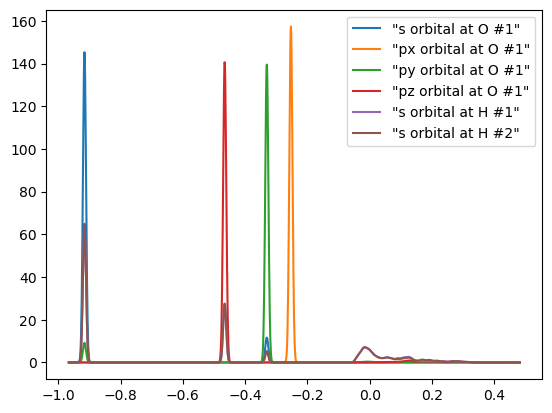

In [17]:
import matplotlib.pyplot as plt
for i, h in enumerate(header[1:]):
    plt.plot(data[0], data[i+1], label=h)
plt.legend()

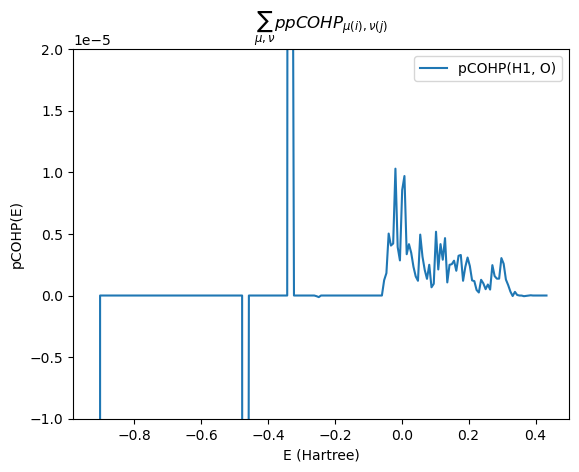

In [25]:
import matplotlib.pyplot as plt
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]

plt.plot(Egrid, pCOHP_sum, label='pCOHP(H1, O)')
plt.ylim(-0.00001, 0.00002)
plt.title(r'$\sum_{\mu,\nu}ppCOHP_{\mu(i),\nu(j)}$')
plt.xlabel('E (Hartree)')
plt.ylabel('pCOHP(E)')
plt.legend()
plt.savefig('ppCOHP_H1_O_zoom.png', bbox_inches='tight', facecolor='white')

In [19]:
gaussian_energies = [
	-0.93811, -0.49418, -0.32553, -0.26299, 0.00273, 0.09722, 0.15203
]
gaussian_plot_energies = []
gaussian_plot_ocs = []
dE = 0.001
occ_height = 50
for e in gaussian_energies:
	gaussian_plot_energies.append(e - 2*dE)
	gaussian_plot_energies.append(e - dE)
	gaussian_plot_energies.append(e + dE)
	gaussian_plot_energies.append(e + 2*dE)
	gaussian_plot_ocs.append(0)
	gaussian_plot_ocs.append(occ_height)
	gaussian_plot_ocs.append(-occ_height)
	gaussian_plot_ocs.append(0)

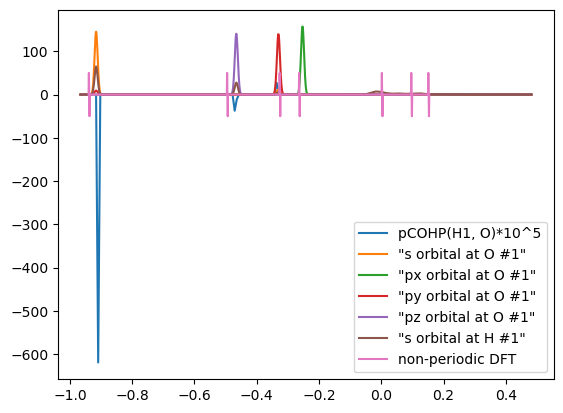

In [20]:
import matplotlib.pyplot as plt
pts = 200
minE = np.min(E)
maxE = np.max(E)
dE = (maxE - minE)/pts
Egrid = np.arange(minE, maxE + dE, dE)
#orb_idcs = H1(1s),O(2s),O(px),O(py),O(pz)
orb_idcs = [1,2,3,4,5]
H_orb_idcs = [0]
Ox_orb_idcs = [2,3,4,5]
pCOHP_sum = np.zeros(np.shape(Egrid))
for u in H_orb_idcs:
	for v in Ox_orb_idcs:
		pCOHP_sum += pCOHP_uv(u, v, minE, maxE, dE)[0]
plt.plot(Egrid, pCOHP_sum*(10**5), label='pCOHP(H1, O)*10^5')
for i, h in enumerate(header[1:-1]):
    plt.plot(data[0], data[i+1], label=h)
plt.plot(gaussian_plot_energies, gaussian_plot_ocs, label='non-periodic DFT')
plt.legend()
plt.savefig('pCOHP_and_pDOS_water_2.png')